<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Graphs and Networks</h1>
<h2>Lesson III - Graph Algorithms</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

Watermark the notebook with current versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

matplotlib 3.1.0
watermark  1.8.1
numpy      1.16.2
Wed Sep 25 2019 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 90797a3cf60135c58852867b0490dde3aa2fedb5


We import the previous Graph Class definition

In [3]:
from Graph import *

In [4]:
G = Graph()

In [5]:
dir(G)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_distribution',
 '_directed',
 '_edges',
 '_nodes',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'degree_distribution',
 'degrees',
 'edges',
 'is_directed',
 'neighbour_degree',
 'neighbour_degree_function',
 'neighbours',
 'number_of_edges',
 'number_of_nodes',
 'weight_distribution',
 'weights']

# Graph Models

## Erdős-Rényi 

Graph models are simple algorithms to generate graph topologies. We start with Erdős-Rényi model where each pair of nodes is added with a fixed probability

In [6]:
@add_method(Graph)
def erdos_renyi_graph(N, p):
    nodes = list(range(N))
    edges = []
    
    for i in range(N):
        for j in range(i+1, N):
            if np.random.random() < p:
                edges.append((i, j))
    
    G = Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G

Let's generate a relatively small ER graph

In [7]:
ER = Graph.erdos_renyi_graph(10000, 0.01)

With these parameters, we expect the average degree to be $\langle k\rangle=Np=100$ and the distribution to be approximately Gaussian. We start by generating the degre distribution

In [8]:
Pk = ER.degree_distribution()

And make a quick plot to verify it's shape

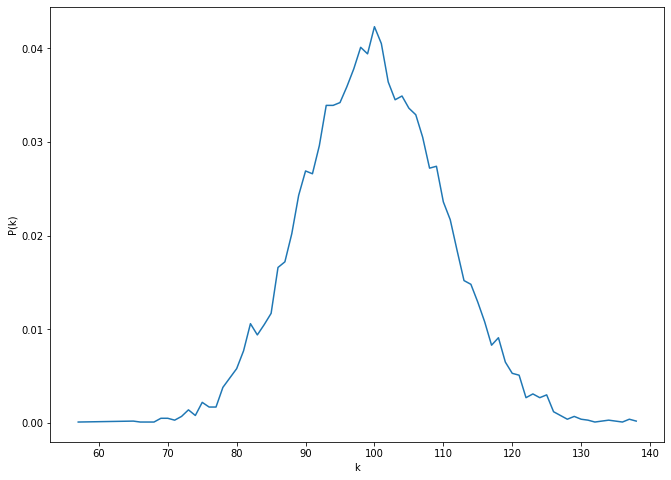

In [9]:
plt.plot(Pk.T[0], Pk.T[1])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.gcf().set_size_inches(11, 8)

Finally, the average degree is, simply:

$$\langle k \rangle=\sum_k k P(k)$$

In [10]:
kavg = np.dot(Pk.T[0], Pk.T[1])
print(kavg)

99.8232


## Regular Ring

We now proceed to defining a regular ring graph where each node is connected with K/2 neighbors on the left and K/2 neighbours on the right. This will be a stepping stone towards the full fledged Watts-Strogats model

In [11]:
@add_method(Graph)
def ring_graph(N, K):
    nodes = np.arange(N)
    edges = []
    
    K = K//2
    
    for i in range(N):
        for j in range(i+1, i+K+1):
            edges.append((i, j%N))
        
    G = Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

To generate a small regular ring we simply do

In [12]:
RG = Graph.ring_graph(100, 4)

Naturally the degree distribution is pretty simple

In [13]:
Pk = RG.degree_distribution()

With all nodes having degree 4

In [14]:
Pk

array([[4., 1.]])

## Watts-Strogatz model

The first step towards defining a WS model is to implementing the rewiring procedure. This takes an existing graph and randomly rewires it's edges with probability $p$

In [15]:
@add_method(Graph)
def _rewire(self, p):
    node_labels = list(self._nodes.keys())
    nodes = dict(zip(node_labels, range(len(node_labels))))
    
    edges = self.edges()
        
    for node_i, node_j, data in edges:
        if nodes[node_j] > nodes[node_i]: # Make sure we just rewire one end of the edge
            prob = np.random.random()

            if prob < p:
                new_node_j = node_labels[np.random.randint(len(node_labels))]
                self._edges[node_i][new_node_j] = self._edges[node_i][node_j]
                self._edges[node_i].pop(node_j)

                self._edges[new_node_j][node_i] = self._edges[node_j][node_i]
                self._edges[node_j].pop(node_i)

So if we apply it to the previous graph, we significantly impact the degree distribution

In [16]:
RG = Graph.ring_graph(10000, 4)
RG._rewire(0.3)
Pk = RG.degree_distribution()

Which is now significantly broader while still peaked at 4

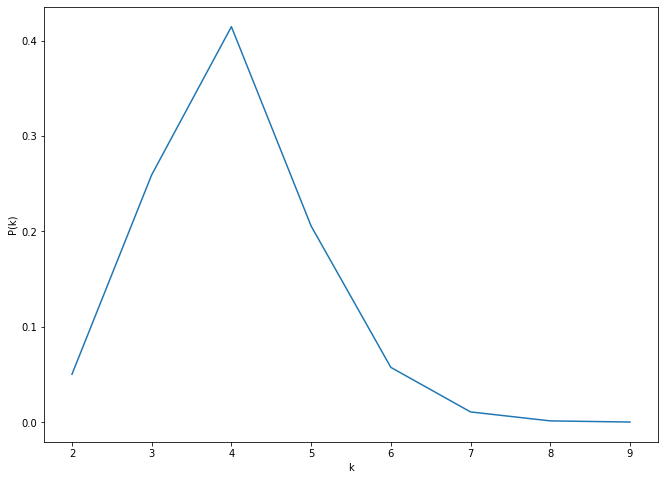

In [17]:
plt.plot(Pk.T[0], Pk.T[1])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.gcf().set_size_inches(11, 8)

The Watts-Strogatz model is then, simply

In [18]:
@add_method(Graph)
def watts_strogatz_graph(N, K, p):
    G = Graph.ring_graph(N, K)
    G._rewire(p)
    
    return G

## Barabasi-Albert model

For the sake of completeness we also implement the Barabasi-Albert model in the simple case where we start with 3 fully connected nodes and add one edge at each time step

In [19]:
@add_method(Graph)
def barabasi_albert_graph(N):
    G = Graph()

    nodes = range(N)
    G.add_nodes_from(nodes)

    edges = [0,1,1,2,2,0]

    for node_i in range(3, N):
        pos = np.random.randint(len(edges))
        node_j = edges[pos]

        edges.append(node_i)
        edges.append(node_j)

    edges = zip(nodes, edges[1::2])

    G.add_edges_from(edges)

    return G

As expected, the degree distribution is broad tailed

In [20]:
BA = Graph.barabasi_albert_graph(100000)
Pk = BA.degree_distribution()

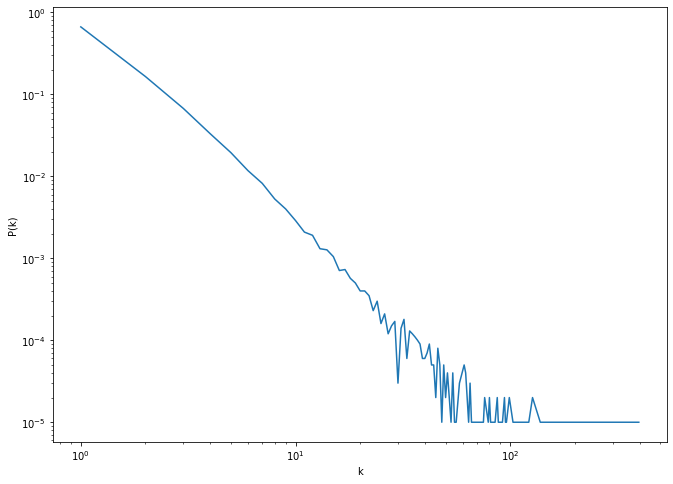

In [21]:
plt.loglog(Pk.T[0], Pk.T[1])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.gcf().set_size_inches(11, 8)

# Viral Spreading

We now consider the case of viral spreading on a network. This is a similar process to what you might observe in the case of rumor or inovation spreading in a social network. At each step, the "healthy" neighbors of any of the infectious nodes gets infected with fixed probability $p$. We also keep track of every configuration for later analysis

In [22]:
@add_method(Graph)
def viral(self, beta, timesteps, seed):
    N = len(self._nodes)

    configuration = np.zeros((timesteps, N), dtype='int')
    configuration[0, seed] = 1

    for t in range(0, timesteps-1):
        configuration[t+1] = np.copy(configuration[t])

        for i in range(N):
            if configuration[t][i] == 1:
                for neighbour in self.neighbours(i):
                    if configuration[t][neighbour] == 0:
                        prob = np.random.random()

                        if prob < beta:
                            configuration[t+1][neighbour] = 1

                        break

    return configuration

And we make a quick comparison of how innovations spread in two simple networks, ER and WS

In [23]:
WS = Graph.watts_strogatz_graph(100, 4, 0.02)
ER = Graph.erdos_renyi_graph(100, 0.1)

We start the infection from a randomly chosen location

In [24]:
seed = np.random.randint(100)

And capture all the configurations over the course of 100 timesteps

In [25]:
WS_configuration = WS.viral(0.1, 100, seed)
ER_configuration = ER.viral(0.1, 100, seed)

In [26]:
WS_configuration

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

When we plot them side by side, the difference becomes clear with ER showing the "infection" spreading randomly across the network and the WS infection being more limited to a specific area of the graph until it encounters a long range link

Text(0.5, 1.0, 'Watts-Strogatz')

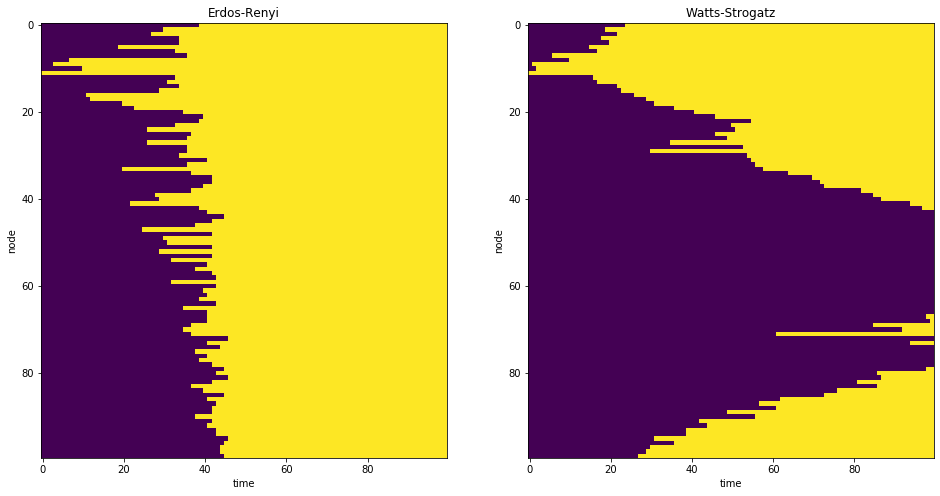

In [27]:
fig, ax_lst = plt.subplots(1, 2, figsize=(16, 8))
ax_lst[0].imshow(ER_configuration.T, aspect='auto')
ax_lst[0].set_xlabel('time')
ax_lst[0].set_ylabel('node')
ax_lst[0].set_title('Erdos-Renyi')

ax_lst[1].imshow(WS_configuration.T, aspect='auto')
ax_lst[1].set_xlabel('time')
ax_lst[1].set_ylabel('node')
ax_lst[1].set_title('Watts-Strogatz')

The differences are also striking when we look at the number of reached individuals as a function of time, with ER networks being significantly faster

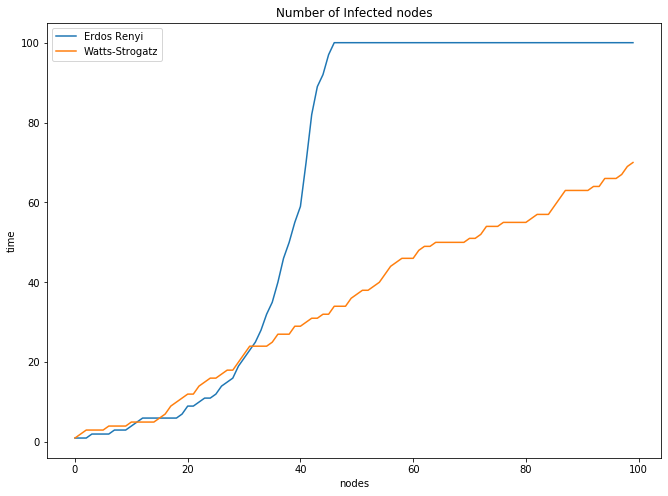

In [28]:
plt.plot(np.sum(ER_configuration, axis=1), label='Erdos Renyi')
plt.plot(np.sum(WS_configuration, axis=1), label="Watts-Strogatz")
plt.title('Number of Infected nodes')
plt.xlabel('nodes')
plt.ylabel('time')
plt.legend()
plt.gcf().set_size_inches(11, 8)

# Random Walks and Paths

As we saw, a path on a graph is simply a sequence of visited nodes. Here we implement a simple random_walk over a graph to generate the sequence of visited nodes. 

In [29]:
@add_method(Graph)
def random_walk(self, source, steps):
    path = [source]
    
    for i in range(steps):
        source = path[-1]
        NN = [node for node in self._edges[source]]
        
        chosen = NN[np.random.randint(len(NN))]
        path.append(chosen)
        
    return path

We generate a path of 1,000,000 steps

In [30]:
path = BA.random_walk(0, 1000000)

And count how many times each node is visited

In [31]:
visits = Counter(path)
counts = list(visits.items())
counts.sort(key=lambda x:x[1], reverse=True)

The top 10 most visited nodes are:

In [32]:
counts[:10]

[(7, 3355),
 (53, 2344),
 (24, 2289),
 (69, 2235),
 (0, 2180),
 (20, 1102),
 (31, 1095),
 (90, 998),
 (187, 966),
 (1078, 935)]

For comparison, their degrees are:

In [33]:
deg = BA.degrees()
top10 = [i for i, j in counts[:10]]

for i, node in enumerate(top10):
    print(node, deg[node], counts[i][1])

7 397 3355
53 171 2344
24 212 2289
69 153 2235
0 285 2180
20 62 1102
31 83 1095
90 87 998
187 99 966
1078 62 935


And we clearly see that the number of visits is strongly correlated with the node degree. To make it clearer

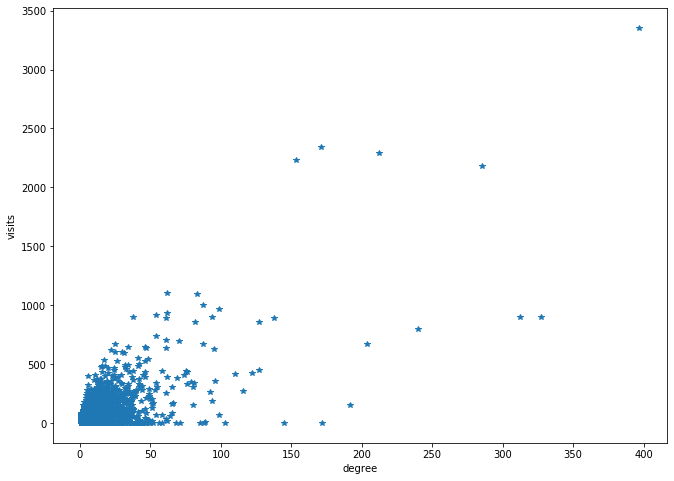

In [34]:
data = []

for node in deg:
    data.append((deg[node], visits[node]))
    
data = np.array(data)

plt.plot(data.T[0], data.T[1], '*')
plt.xlabel('degree')
plt.ylabel('visits')
plt.gcf().set_size_inches(11, 8)

# PageRank

The first step is generating the Google Matrix of the graph. For this we require the adjacency matrix, so we start there

In [35]:
@add_method(Graph)
def adjacency_matrix(self):
    N = len(self._nodes)
    A = np.zeros((N, N), dtype='float')
    
    for node_i in self._edges:
        for node_j in self._edges[node_i]:
            A[node_i, node_j] = 1
            
    return A

The Google Matrix is then given by:

In [36]:
@add_method(Graph)
def google_matrix(self, m):
    A = self.adjacency_matrix()
    N = A.shape[0]
    v = np.ones(N)

    KT = np.dot(A, v)
    A = A.T

    for i in range(N):
        if KT[i] != 0:
            A.T[i] = A.T[i]/KT[i]
        else:
            A.T[i] = np.ones(N)/float(N)

    S = np.ones((N, N))/N
    G = (1-m)*A+m*S

    return G

In order to calculate the pagerank value of each node we will need to use the Power Method. We define it now

In [37]:
@add_method(Graph)
def Power_Method(self, m, n_iter):
    G = self.google_matrix(m)
    N = G.shape[0]
    x0 = np.ones(N)/N

    for i in range(n_iter):
        x1 = np.copy(x0)
        x0 = np.dot(G, x0)
        
        if np.sum(np.abs(x1-x0)) < 1e-10:
            break

    return x0

For the sake of expediency, we will use a smaller version of the BA graph defined above

In [38]:
BA = Graph.barabasi_albert_graph(1000)

In [39]:
pagerank = BA.Power_Method(0.15, 100)

And we compare it with the degree distribution

In [40]:
deg = BA.degrees()

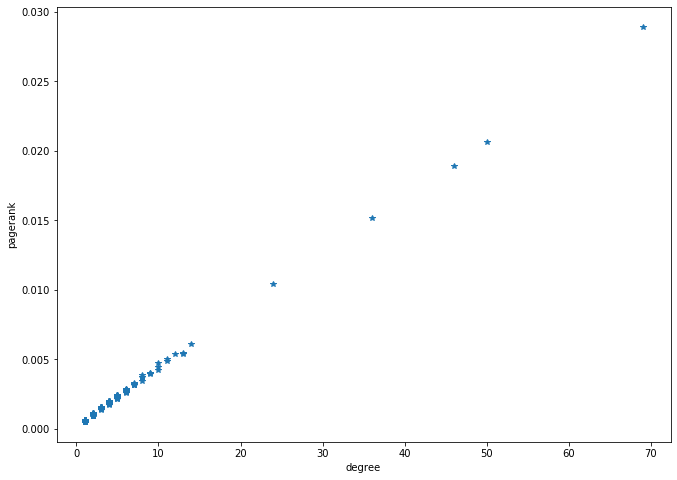

In [41]:
data = []

for node in range(1000):
    data.append((deg[node], pagerank[node]))
    
data = np.array(data)
plt.plot(data.T[0], data.T[1], '*')
plt.xlabel('degree')
plt.ylabel('pagerank')
plt.gcf().set_size_inches(11, 8)

As expected, it is strongly correlated with the degree (important pages are linked to by many other pages) but with important fluctuations due to the local network structure. These variations become even stronger in larger, directed graphs such as the WWW

# Sampling Methods

We also consider sampling approaches. These are often used when we must interact with some system (call an API, perform interviews, etc) to extract information about the network structure.

We start with the random walk sampling. This is just a random walk on the graph as we saw above. 

In [42]:
@add_method(Graph)
def random_walk_sample(self, source, maxsteps=1000):
    seen = []
    queue = source
    
    for _ in range(maxsteps+1):
        user_id = queue
        seen.append(user_id)

        NN = list(self.neighbors(user_id))
        
        # Randomly select one of the neighbors
        queue = NN[np.random.randint(len(NN))]

    return seen

On the other hand, snowball sampling returns a compact set of nodes that forms a denser connected component

In [43]:
@add_method(Graph)
def snowball_sample(self, source, max_depth = 3):
    seen = set()
    queue = set()

    queue.add(source)
    queue2 = set()

    for _ in range(max_depth+1):
        while queue:
            user_id = queue.pop()
            seen.add(user_id)

            NN = self.neighbours(user_id)

            for node in NN:
                if node not in seen:
                    queue2.add(node)

        queue.update(queue2)
        queue2 = set()

    return seen

In the simple case of the WS model it is easy to see the regular structure of the graph with just a few nodes returned

In [44]:
seen = WS.snowball_sample(0)

In [45]:
seen

{0, 1, 2, 3, 4, 5, 6, 29, 94, 95, 96, 97, 98, 99}

For comparison, we can also see how differnet the BA model is by performing a snowball sample with similar parameters 

In [46]:
seen = BA.snowball_sample(0)

In [47]:
len(seen)

568

Here we recover almost the entirety of the graph. The reason for this is simple: in a graph with a broad tailed distribution we quickly reach one (or more) of the hubs that are connected to a significant portion of the total graph. 

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>